In [2]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as np
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
(XTrain,_),(_,_) = mnist.load_data()

In [4]:
print(XTrain.shape)

(60000, 28, 28)


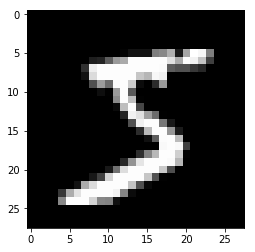

In [5]:
plt.imshow(XTrain[0],cmap='gray')
plt.show()

## Normalizing the Data

In [6]:
XTrain = (XTrain.astype('float32') - 127.5) /127.5
print(np.min(XTrain))
print(np.max(XTrain))
print(XTrain.shape)

-1.0
1.0
(60000, 28, 28)


In [7]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(XTrain.shape[0]/BATCH_SIZE)
HALF_BATCH =128
NOISE_DIM = 100 # UMSAMPLE INTO 784 DIM VECTOR
adam = Adam(lr=2e-4,beta_1=0.5) # This parameters work well for GAN

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# CODE FOR GENERATOR
# INPUT NOISE (100 dim ) and output a vector (784 dim)


generator = Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))
generator.compile(loss = 'binary_crossentropy',optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [9]:
# Discriminator

discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy',optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
